In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd drive/'My Drive'/projects/deep_learning_school/16_HW_Semantic_Segmentation/

/content/drive/My Drive/projects/deep_learning_school/16_HW_Semantic_Segmentation


In [6]:
%ls

'Copy of [hw]semantic_segmentation.ipynb'   PH2Dataset/


# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>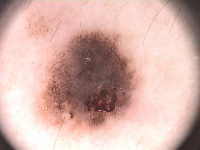</td><td>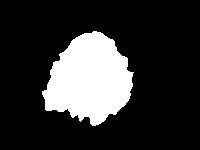</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [7]:
# works
# ! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

In [8]:
# works
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [9]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    # img files are in <ID>_Dermoscopic_Image folders
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))

    # mask files are in <ID>_lesion folders
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [10]:
from skimage.transform import resize
size = (256, 256)

"""
Resize signature:

resize(image, output_shape, order=None, mode='reflect', cval=0, clip=True,
       preserve_range=False, anti_aliasing=None, anti_aliasing_sigma=None)


mode {‘constant’, ‘edge’, ‘symmetric’, ‘reflect’, ‘wrap’}, optional
    Points outside the boundaries of the input are filled according to the given
    mode. Modes match the behaviour of numpy.pad.

anti_aliasing bool, optional
    Whether to apply a Gaussian filter to smooth the image prior to down-scaling.
    It is crucial to filter when down-sampling the image to avoid aliasing artifacts.
    If input image data type is bool, no anti-aliasing is applied.
"""

X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [11]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [12]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

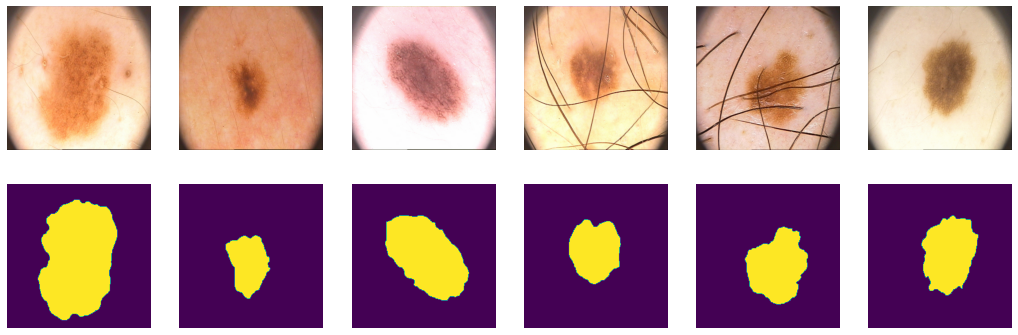

In [13]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [14]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [15]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [16]:
from torch.utils.data import DataLoader
batch_size = 25 # since the sizes are 100, 50, and 50 images


data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [17]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

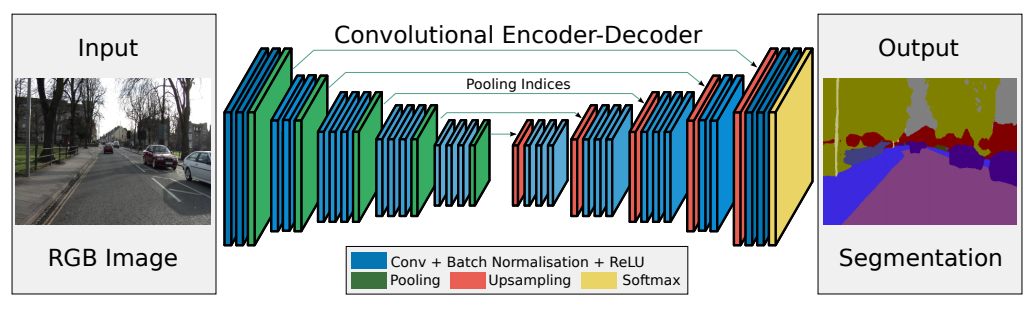

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

import torchsummary

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [19]:
class SegNet(nn.Module):

    def conv_block(self, channel_in, channel_out):
        return torch.nn.Sequential(
            torch.nn.Conv2d(channel_in, channel_out, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(channel_out),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(channel_out, channel_out, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(channel_out),
            torch.nn.ReLU(inplace=True)
        )

    def conv_transpose_block(self, channel_in, channel_out):
        return torch.nn.Sequential(
            torch.nn.ConvTranspose2d(channel_in, channel_out, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(channel_out),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(channel_out, channel_out, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(channel_out),
            torch.nn.ReLU(inplace=True)
        )

    def __init__(self, channel_in=3, channel_out=1, bilinear=None):
        super(SegNet, self).__init__()
        self.channel_in = channel_in
        self.channel_out = channel_out

        # encoder (downsampling)
        #
        # Note, we need different pooling layers because we need them to record indices
        #
        self.enc_conv0 = self.conv_block(channel_in, 32)
        self.pool0 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = self.conv_block(32, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = self.conv_block(256, 256)

        # decoder (upsampling)
        self.upsample3 = nn.MaxUnpool2d(kernel_size=(2, 2), stride=2) # 16 -> 32
        self.dec_conv3 = self.conv_transpose_block(256, 128)
        self.upsample2 = nn.MaxUnpool2d(kernel_size=(2, 2), stride=2) # 32 -> 64
        self.dec_conv2 = self.conv_transpose_block(128, 64)
        self.upsample1 = nn.MaxUnpool2d(kernel_size=(2, 2), stride=2) # 64 -> 128
        self.dec_conv1 = self.conv_transpose_block(64, 32)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=(2, 2), stride=2) # 128 -> 256
        self.dec_conv0 = self.conv_transpose_block(32, channel_out)

    def forward(self, x):
        # encoder
        e0, ind_0 = self.pool0(self.enc_conv0(x))
        e1, ind_1 = self.pool1(self.enc_conv1(e0))
        e2, ind_2 = self.pool2(self.enc_conv2(e1))
        e3, ind_3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d3 = self.dec_conv3(self.upsample3(b, ind_3))
        d2 = self.dec_conv2(self.upsample3(d3, ind_2))
        d1 = self.dec_conv1(self.upsample3(d2, ind_1))
        d0 = self.dec_conv0(self.upsample3(d1, ind_0))  # no activation

        return d0

model = SegNet()
torchsummary.summary(model, (3, 256, 256), device="cpu") # Runs a basic test of the network. Very useful and clear!

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7  [[-1, 32, 128, 128], [-1, 32, 128, 128]]               0
            Conv2d-8         [-1, 64, 128, 128]          18,496
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,928
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14  [[

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## функция лосса [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
a = torch.randn((4, 256, 256))
b = torch.randn((4, 256, 256))
c = a - a * b + torch.log(1 + torch.exp(-a))
res = torch.sum(c)
print(res.shape)
print(res)

torch.Size([])
tensor(211408.2031)


In [ ]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    return torch.mean(y_pred - y_pred * y_real + torch.log(1 + torch.exp(-y_pred)))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    X_val, Y_val = X_val.to(device), Y_val.to(device)

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            print("Y_batch.shape", Y_batch.shape)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            print("Y_pred.shape", Y_pred.shape)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val).detach().cpu() # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ model(X_batch.to(device)) for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch, Y_label = X_batch.to(device), Y_label.to(device)
        Y_pred = model(X_batch)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

In [ ]:
model = SegNet().to(device)

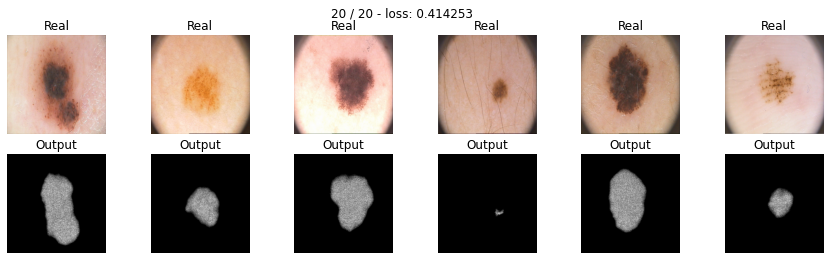

In [ ]:
max_epochs = 20
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fn = iou_

train(model, optim, loss_fn, max_epochs, data_tr, data_val)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.041999999433755875

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

**Не забудьте подумать о численной нестабильности.**


In [ ]:
def dice_loss(y_real, y_pred):
    SMOOTH = 1e-8

    batch_size = y_real.shape[0]

    num = 2 * y_real * y_pred
    den = y_real + y_pred
    
    res = 1 - 1/(256 * 256 * batch_size) * torch.sum((num + SMOOTH) / (den + SMOOTH))
    return res 

Проводим тестирование:

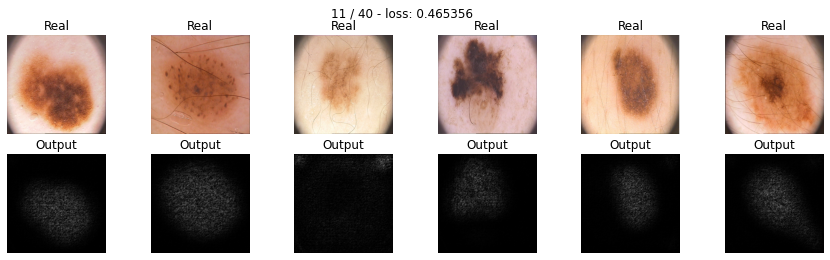

* Epoch 12/40
Y_batch.shape torch.Size([25, 1, 256, 256])
Y_pred.shape torch.Size([25, 1, 256, 256])
Y_batch.shape torch.Size([25, 1, 256, 256])
Y_pred.shape torch.Size([25, 1, 256, 256])
Y_batch.shape torch.Size([25, 1, 256, 256])
Y_pred.shape torch.Size([25, 1, 256, 256])
Y_batch.shape torch.Size([25, 1, 256, 256])
Y_pred.shape torch.Size([25, 1, 256, 256])
loss: 0.435054


In [ ]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred =  # hint: torch.clamp
    return your_loss

In [ ]:
model_focal = SegNet(channel_in=3, channel_out=1).to(device)

max_epochs = 40
optimaizer = optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаю написать вам 1 функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Tversky loss
5) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

In [ ]:
<TODO>

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

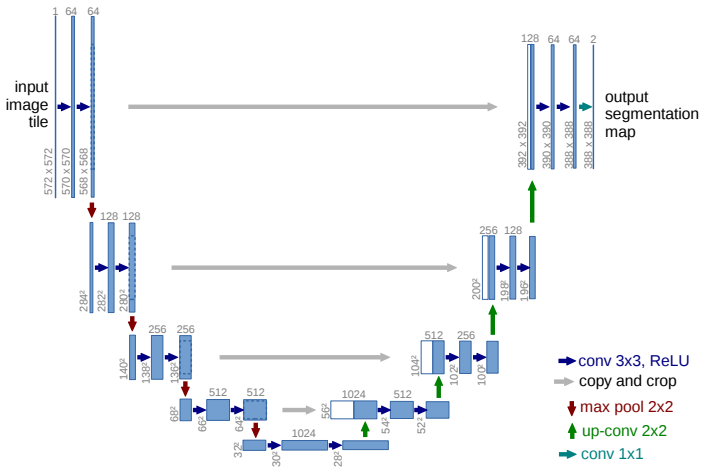

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
# Define your model. In this case we're using a basic UNet architecture. The output channel for segmentation should be equal to number of classes we want to segment the image into. For a binary segmentation, this is a value of 1.
class UNet(torch.nn.Module):

    def conv_block(self, channel_in, channel_out):
        return torch.nn.Sequential(
            torch.nn.Conv2d(channel_in, channel_out, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(channel_out),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(channel_out, channel_out, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(channel_out),
            torch.nn.ReLU(inplace=True)
        )


    def __init__(self, channel_in, channel_out, bilinear=None):
        super(UNet, self).__init__()
        self.channel_in = channel_in
        self.channel_out = channel_out
        
        # initial convolutional block
        self.initial = self.conv_block(channel_in, 64)
        
        # encoder layers
        self.down0 = self.conv_block(64, 128)
        self.down1 = self.conv_block(128, 256)
        self.down2 = self.conv_block(256, 512)
        self.down3 = self.conv_block(512, 1024)
        
        # decoder layers
        self.up0_0 = torch.nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up0_1 = self.conv_block(1024, 512)
        self.up1_0 = torch.nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up1_1 = self.conv_block(512, 256)
        self.up2_0 = torch.nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up2_1 = self.conv_block(256, 128)
        self.up3_0 = torch.nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up3_1 = self.conv_block(128, 64)
        
        # final layer before output
        self.final = torch.nn.Conv2d(64, channel_out, kernel_size=1)

    def forward(self,x):
        "Forward pass"
        x_in= self.initial(x)
        enc0 = self.down0(torch.nn.MaxPool2d(2)(x_in))
        enc1 = self.down1(torch.nn.MaxPool2d(2)(enc0))
        enc2 = self.down2(torch.nn.MaxPool2d(2)(enc1))
        enc3 = self.down3(torch.nn.MaxPool2d(2)(enc2))
        
        dec0 = self.up0_0(enc3)
        diff0 = torch.FloatTensor(list(enc2.size())[2:]) - torch.FloatTensor(list(dec0.shape))[2:]
        dec0 = torch.nn.functional.pad(dec0, (int((diff0/2).floor()[0]), int((diff0/2).ceil()[0]), int((diff0/2).floor()[1]), int((diff0/2).ceil()[1])))
        dec0 = self.up0_1(torch.cat((enc2, dec0), dim=1))

        dec1 = self.up1_0(dec0)
        diff1 = torch.FloatTensor(list(enc1.size())[2:]) - torch.FloatTensor(list(dec1.shape))[2:]
        dec1 = torch.nn.functional.pad(dec1, (int((diff1/2).floor()[0]), int((diff1/2).ceil()[0]), int((diff1/2).floor()[1]), int((diff1/2).ceil()[1])))
        dec1 = self.up1_1(torch.cat((enc1, dec1), dim=1))

        dec2 = self.up2_0(dec1)
        diff2 = torch.FloatTensor(list(enc0.size())[2:]) - torch.FloatTensor(list(dec2.shape))[2:]
        dec2 = torch.nn.functional.pad(dec2, (int((diff2/2).floor()[0]), int((diff2/2).ceil()[0]), int((diff2/2).floor()[1]), int((diff2/2).ceil()[1])))
        dec2 = self.up2_1(torch.cat((enc0, dec2), dim=1))

        dec3 = self.up3_0(dec2)
        diff3 = torch.FloatTensor(list(x.size())[2:]) - torch.FloatTensor(list(dec3.shape))[2:]
        dec3 = torch.nn.functional.pad(dec3, (int((diff3/2).floor()[0]), int((diff3/2).ceil()[0]), int((diff3/2).floor()[1]), int((diff3/2).ceil()[1])))
        dec3 = self.up3_1(torch.cat((x_in, dec3), dim=1))

        x_out = self.final(dec3)
        return x_out

model = UNet(channel_in=3, channel_out=1)
torchsummary.summary(model, (3, 256, 256), device="cpu") # Runs a basic test of the network. Very useful and clear!

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
            Conv2d-7        [-1, 128, 128, 128]          73,856
       BatchNorm2d-8        [-1, 128, 128, 128]             256
              ReLU-9        [-1, 128, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]         147,584
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
           Conv2d-13          [-1, 256, 64, 64]         295,168
      BatchNorm2d-14          [-1, 256,

In [ ]:
unet_model = UNet(channel_in=3, channel_out=1).to(device)

In [ ]:
train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 20, data_tr, data_val)

AttributeError: ignored

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):


In [ ]:
unet2_model = UNet2().to(device)


In [ ]:
train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 5, data_tr, data_val)

Сделайте вывод какая из моделей лучше

# Dilated convolutions [1 балл]



Еще один из вариантов делать upsampling и downsampling - использовать для этого *dilated convolutions*:


* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

попробуйте написать сеть DilatedUNet, которая использует в одной из предыдущих моделей dilated свертки.

In [ ]:
class DilatedSegNet(nn.Module):
    def __init__(self):
        super().__init__()

In [ ]:
model = DilatedSegNet().to(device)

In [ ]:
train(model, optim.Adam(model.parameters()), bce_loss, 20, data_tr, data_val)

# Отчет (5 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверябщий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

